In [1]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pyfits
import pymodelfit
import pyraf
from pyraf import iraf
execfile("/Users/azuri/entwicklung/python/myUtils.py")# import getDate, findClosestDate

%matplotlib inline

starPosCCD = [1048+256,1024]

def countObjectColumns(areas):
    nCols = 0
    for area in areas:
        nCols += area[1]-area[0]
    return nCols

def findFirstIdxWithValGT(valueArr, val):
    idx = 0
    while valueArr[idx] < val:
        idx += 1
    return idx

def populateSkyArray(imageData, area):
    sky = np.copy(imageData[:,area[0]:area[1]])
    return sky

def populateObjectArray(imageData, areas):
    nCols = countObjectColumns(areas)
    print 'nCols = ',nCols
    obsCols = np.zeros(shape=(imageData.shape[0],nCols), dtype=type(imageData[0,0]))
    nCols = 0
    for area in areas:
#        print 'imageData[1000,',area[0],':',area[1],'] = ',imageData[1000,area[0]:area[1]]
        obsCols[:,nCols:nCols+area[1]-area[0]] = np.copy(imageData[:,area[0]:area[1]])
        nCols += area[1]-area[0]
    return obsCols

# --- fit y = a*x + b
# --- return value w: w[0] = a, w[1] = b
def linReg(x,y):
    oneD = False
    if (len(y.shape) < 2):
        oneD = True
    A = np.array([ x, np.ones(len(x))])
#    print 'linReg: A = ',A
#    print 'linReg: A.T = ',A.T
#    print 'linReg: x.shape = ',x.shape,', A.shape = ',A.shape,', y.shape = ',y.shape
    if not oneD:
        w = []
        for iy in range(y.shape[0]):
            w.append(np.linalg.lstsq(A.T,y[iy,:])[0])
    #        print 'linReg: iy = ',iy,': w[',iy,'] = ',w[iy]
    else:
#        print 'A.shape = ',A.shape
#        print 'y.shape = ',y.shape
        w = np.linalg.lstsq(A.T,y)[0]
    return w

# axis: 0 (columns) or 1 (rows)
# width: odd number
def boxCarMedianSmooth(imageData, axis, width):
    print 'imageData.shape = ',imageData.shape
    print 'len(imageData.shape) = ',len(imageData.shape)
    print 'imageData = ',imageData
    newDataArray = None
    if len(imageData.shape) > 1:
        newDataArray = np.zeros(shape=imageData.shape, dtype=type(imageData[0,0]))
        if axis == 0:
            for iRow in range(imageData.shape[0]):
                for iCol in range(imageData.shape[1]):
                    if iCol < int(width/2.0):
                        iColStart = 0
                        iColEnd = iCol+int(width/2.0)+1
                    elif iCol > imageData.shape[1]-int(width/2.0)-1:
                        iColStart = iCol - int(width/2.0)
                        iColEnd = imageData.shape[1]
                    else:
                        iColStart = iCol - int(width/2.0)
                        iColEnd = iCol + int(width/2.0) + 1
                    newDataArray[iRow,iCol] = np.median(imageData[iRow,iColStart:iColEnd])
    #                print 'iRow = ',iRow,', iCol = ',iCol,': iColStart = ',iColStart,', iColEnd = ',iColEnd,': imageData[iRow,iColStart:iColEnd] = ',imageData[iRow,iColStart:iColEnd],': median = ',newDataArray[iRow,iCol]
        elif axis == 1:
            for iCol in range(imageData.shape[1]):
                for iRow in range(imageData.shape[0]):
                    if iRow < int(width/2.0):
                        iRowStart = 0
                        iRowEnd = iRow+int(width/2.0)+1
                    elif iRow > imageData.shape[0]-int(width/2.0)-1:
                        iRowStart = iRow - int(width/2.0)
                        iRowEnd = imageData.shape[1]
                    else:
                        iRowStart = iRow - int(width/2.0)
                        iRowEnd = iRow + int(width/2.0) + 1
                    newDataArray[iRow,iCol] = np.median(imageData[iRowStart:iRowEnd,iCol])
    #                print 'iCol = ',iCol,', iRow = ',iRow,': iRowStart = ',iRowStart,', iRowEnd = ',iRowEnd,': imageData[iRowStart:iRowEnd,iCol] = ',imageData[iRowStart:iRowEnd,iCol],': median = ',newDataArray[iRow,iCol]
        else:
            print 'ERROR: axis(=',axis,') out of bounds [0,1]'
    else:
        newDataArray = np.zeros(shape=imageData.shape, dtype=type(imageData[0]))
        for iCol in range(imageData.shape[0]):
            if iCol < int(width/2.0):
                iColStart = 0
                iColEnd = iCol+int(width/2.0)+1
            elif iCol > imageData.shape[0]-int(width/2.0)-1:
                iColStart = iCol - int(width/2.0)
                iColEnd = imageData.shape[0]
            else:
                iColStart = iCol - int(width/2.0)
                iColEnd = iCol + int(width/2.0) + 1
            newDataArray[iCol] = np.median(imageData[iColStart:iColEnd])
    return newDataArray

def sigmaRej(values, sigLow, sigHigh, adjustSigLevels):
    ySkyMedian = np.median(values)
    sigma = np.std(values)
    nRej = 0
    if adjustSigLevels:
        if sigma > 3. * ySkyMedian:
            sigLow = 0.5
            sigHigh = 0.05
    for i in range(len(values)):
        if (values[i] < ySkyMedian - (sigLow * sigma)) or (values[i] > ySkyMedian + (sigHigh * sigma)):
            values[i] = ySkyMedian
            nRej += 1
#            print 'subtractSky: median = ',ySkyMedian,', sigma = ',sigma,': removed pixel ',i,' from sky'
#    print 'sigmaRej: rejected ',nRej,' out of ',len(values),' pixels'
    return values

# --- in case of 1D image data replace the area [skyLeftArea[1]:skyRightArea[0]] with the interpolated 'sky'
# --- otherwise subtract the 2D sky image from the 2D image data
def subtractSky(imageData,skyLeftArea,skyRightArea):
    dtype = None
    axis = None
    oneD = False
    if (len(imageData.shape) > 1):
        dtype = type(imageData[0,0])
        axis = 1
    else:
        dtype = type(imageData[0])
        oneD = True
        axis = 0
#    print 'oneD = ',oneD
    newImageData = np.ndarray(imageData.shape, dtype=dtype)
    skyData = np.ndarray(imageData.shape, dtype=dtype)
    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
    skyParams = None
    if (oneD):
        skyLeft = imageData[skyLeftArea[0]:skyLeftArea[1]]
        skyLeftSmoothed = boxCarMedianSmooth(skyLeft, 0, 5)
        skyRight = imageData[skyRightArea[0]:skyRightArea[1]]
        skyRightSmoothed = boxCarMedianSmooth(skyRight, 0, 5)
        ySky = np.concatenate([skyLeftSmoothed, skyRightSmoothed])
        ySky = sigmaRej(ySky, 1., 0.3, True)
        skyParams = linReg(xSky,ySky)
    else:
        skyLeft = populateSkyArray(imageData, skyLeftArea)
        skyLeftSmoothed = boxCarMedianSmooth(skyLeft, 0, 9)
        skyRight = populateSkyArray(imageData, skyRightArea)
        skyRightSmoothed = boxCarMedianSmooth(skyRight, 0, 9)
        ySky = np.concatenate([skyLeftSmoothed, skyRightSmoothed],axis=1)
#    print 'subtractSky ySky = ',len(ySky),': ',ySky
#    print 'xSky.shape = ',xSky.shape
#    print 'ySky.shape = ',ySky.shape
#    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: imageData.shape = ',imageData.shape,', newImageData.shape = ',newImageData.shape,', xSky.shape = ',xSky.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
    xObs = np.arange(0.0,imageData.shape[axis],1.0,dtype=dtype)
#    print 'subtractSky: xObs = ',xObs.shape,': ',xObs
    if oneD:
        skyData[:] = (skyParams[0] * xObs) + skyParams[1]
        newImageData[:] = imageData[:]
        newImageData[skyLeftArea[1]:skyRightArea[0]] = skyData[skyLeftArea[1]:skyRightArea[0]]
    else:
        for iRow in range(imageData.shape[0]):
#            print 'subtractSky: iRow = ',iRow
            ySkyRow = sigmaRej(ySky[iRow,:], 1.0, 0.3, True)
            skyParams = linReg(xSky,ySkyRow)
    #        print 'subtractSky: imageData[',iRow,',:] = ',imageData[iRow,:],', newImageData[',iRow,',:].shape = ',newImageData[iRow,:].shape,', skyParams[',iRow,'] = ',len(skyParams[iRow]),': ',skyParams[iRow]
            skyData[iRow,:] = (skyParams[0] * xObs) + skyParams[1]
    #        print 'subtractSky: skyData[',iRow,',:] = ',skyData[iRow,:]
            newImageData[iRow,:] = imageData[iRow,:] - skyData[iRow,:]
    #        print 'subtractSky: newImageData[',iRow,',:] = ',newImageData[iRow,:]
    return [newImageData,skyData]

#def subtractSky(obsAreas,obsData,skyLeftArea,skyLeft,skyRightArea,skyRight):
#    newObsData = np.ndarray(obsData.shape, dtype=type(obsData[0,0]))
##    xSkyLeft = np.arange(skyLeftArea[0],skyLeftArea[1],1.0)
##    xSkyRight = np.arange(skyRightArea[0],skyRightArea[1],1.0)
#    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
#    nCols = 0
#    for area in obsAreas:
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#
#    xObs = np.ndarray(nCols, dtype=type(obsData[0,0]))
#    nCols = 0
#    for area in obsAreas:
#        xObs[nCols:nCols+area[1]-area[0]] = np.arange(area[0],area[1],1.0)
#        print 'subtractSky: area = ',area,': nCols = ',nCols,': xObs[',nCols,':',nCols+area[1]-area[0],'] = ',xObs[nCols:nCols+area[1]-area[0]]
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#    ySky = np.concatenate([skyLeft, skyRight],axis=1)
#    print 'subtractSky = ',len(ySky),': ',ySky
#    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
#    for iRow in range(obsData.shape[0]):
#        print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', obsData[',iRow,',:].shape = ',obsData[iRow,:].shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams)
#        newObsData[iRow,:] = obsData[iRow,:] - ((skyParams[iRow][1] * xObs) + skyParams[iRow][0])
#        print 'subtractSky: newObsData[',iRow,',:] = ',newObsData[iRow,:]
#    STOP
#    return newObsData

def getWavelength(header):
    nPix = int(header['NAXIS2'])
    crPix = int(header['CRPIX2'])
    crVal = float(header['CRVAL2'])
    cDelt = float(header['CDELT2'])
    lam = np.arange(crVal, crVal + (nPix*cDelt), cDelt, dtype=np.float32)
#    print 'getWavelength: lam = ',len(lam),': ',lam
    return lam

def markAreas(imageData, skyAreaLeft, skyAreaRight, objectAreas):
    maxImageData = np.amax(imageData)
    minImageData = np.amin(imageData)
    imageData[:,skyAreaLeft[0]] = minImageData
    imageData[:,skyAreaLeft[1]] = minImageData
    imageData[:,skyAreaRight[0]] = minImageData
    imageData[:,skyAreaRight[1]] = minImageData
    for area in objectAreas:
        imageData[:,area[0]] = maxImageData
        imageData[:,area[1]] = maxImageData

def write1DFits(y, fname, clobber=True):
    hdu = pyfits.PrimaryHDU(y)
    hdu.writeto(fname, clobber=clobber)
    
def read1DFits(fname):
    hdulist = pyfits.open(fname)
    scidata = hdulist[1].data
    hdulist.close()
    return scidata

def specCombineMinimum(imA, imB):
    imOut = np.ndarray(shape = imA.shape, dtype = type(imA[0]))
    for i in range(len(imA)):
        imOut[i] = imA[i]
        if imB[i] < imA[i]:
            imOut[i] = imB[i]
    return imOut

In [ ]:
tab = [
#{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_wl_cal.fits', 'ylim' : [-0.15e-15,0.3e-15], 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ194645', 'SkyLeft':[1110,1260], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-15,1.3e-15], 'OName': 'Kn19', 'SkyLeft':[1141,1166], 'SkyRight':[1474,1504], 'ObjectAreas':[[1200,1228],[1251,1306],[1321,1340],[1358,1407],[1425,1450]]},#looks good
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0003/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.2e-15], 'OName': 'Kn45', 'SkyLeft':[1184,1228], 'SkyRight':[1320,1374], 'ObjectAreas':[[1238,1296]]},#okay, diffuse extended object with continuum
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0004/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ205811', 'SkyLeft':[889,991], 'SkyRight':[1546,1608], 'ObjectAreas':[[1090,1256],[1326,1540]]},#faint line at 5005, very extended object with sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0005/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.2e-14], 'OName': 'DSHJ221013', 'SkyLeft':[680,780], 'SkyRight':[1626,1704], 'ObjectAreas':[[1090,1292],[1334,1380],[1404,1429],[1479,1506],[1538,1554]]},#okay, line at 6562, very extended object with sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0006/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.15e-15], 'OName': 'IPHASXJ194745', 'SkyLeft':[1188,1218], 'SkyRight':[1544,1560], 'ObjectAreas':[[1300,1396]]},#hmmm, run that and try with sky from other image - did try that, still nothing to be seen here
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.1e-14], 'OName': 'Ou3', 'SkyLeft':[1126,1132], 'SkyRight':[1503,1515], 'ObjectAreas':[[1133,1150],[1189,1226],[1241,1300],[1318,1331],[1342,1389],[1407,1432],[1445,1468],[1494,1502]]},#looks good, line at 5004, very extended
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.4e-14], 'OName': 'Kn24', 'SkyLeft':[895,915], 'SkyRight':[1753,1790], 'ObjectAreas':[[916,1038],[1090,1180],[1198,1303],[1320,1556],[1566,1700]]},#looks good, line at 5004, very extended, on both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-16,2.0e-16], 'OName': 'LDu1', 'SkyLeft':[440,570], 'SkyRight':[1837,1918], 'ObjectAreas':[[1106,1134],[1150,1194],[1254,1320],[1338,1348],[1496,1594]]},#looks good, line at 5004 and 6582, very extended, sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.5e-15], 'OName': 'IPHASXJ193617', 'SkyLeft':[1263,1288], 'SkyRight':[1423,1479], 'ObjectAreas':[[1293,1307],[1320,1331]]},#looks good, pretty compact
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'IPHASXJ194728', 'SkyLeft':[1177,1197], 'SkyRight':[1395,1414], 'ObjectAreas':[[1248,1273],[1287,1306],[1323,1350],[1365,1374]]},#looks good, lines at 6716,...
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-14,0.8e-14], 'OName': 'IPHASXJ194301', 'SkyLeft':[1218,1248], 'SkyRight':[1333,1363], 'ObjectAreas':[[1272,1325]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.5e-15], 'OName': 'IPHASXJ194301', 'SkyLeft':[1244,1269], 'SkyRight':[1357,1385], 'ObjectAreas':[[1284,1304],[1324,1348]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'PNG124.1-01.9', 'SkyLeft':[1150,1177], 'SkyRight':[1376,1399], 'ObjectAreas':[[1239,1280],[1299,1350]]},#looks good, lines at 4859 and 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.8e-14], 'OName': 'IPHASXJ014238+600947', 'SkyLeft':[785,816], 'SkyRight':[1930,1956], 'ObjectAreas':[[864,953],[968,1038],[1091,1126],[1138,1303],[1318,1424],[1440,1558],[1564,1595],[1612,1680],[1703,1720],[1759,1902]]},#looks good, lines at 6584, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ031058.8+624755', 'SkyLeft':[243,324], 'SkyRight':[1961,1985], 'ObjectAreas':[[363,457],[478,542],[559,576],[594,726],[743,786],[834,855],[872,897],[910,1038],[1090,1194],[1221,1273],[1328,1436],[1505,1560],[1596,1760],[1785,1850],[1877,1909],[1928,1950]]},#looks good at 4957 and 6579, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.5e-15], 'OName': 'IPHASXj040721.5+512422', 'SkyLeft':[424,522], 'SkyRight':[1842,1891], 'ObjectAreas':[[1197,1303],[1320,1450]]},#looks good, lines at 4959, 5004, 6580, 6716, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-13,0.1e-13], 'OName': 'IPHASXJ051152.2+302751', 'SkyLeft':[662,700], 'SkyRight':[1884,1925], 'ObjectAreas':[[701,1035],[1124,1154],[1171,1300],[1325,1555],[1607,1880]]},#faint emission at 6562, 6580, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.15e-14,0.1e-14], 'OName': 'IPHASXJ053650.8+245616', 'SkyLeft':[1170,1199], 'SkyRight':[1511,1541], 'ObjectAreas':[[1201,1300],[1320,1474]]},#faint lines around 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-14,1.5e-14], 'OName': 'IPHASXJ055242.8+262116', 'SkyLeft':[1233,1248], 'SkyRight':[1534,1545], 'ObjectAreas':[[1265,1294],[1327,1466]]},#looks good, compact, 4959, 5008, 6563
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-2.0e-16,1.5e-16], 'OName': 'IPHASXJ185322.1+083018', 'SkyLeft':[1213,1236], 'SkyRight':[1542,1557], 'ObjectAreas':[[1256,1283],[1322,1358],[1414,1448],[1491,1537]]},#shell visible at 5005
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-14,0.5e-14], 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[572,606], 'SkyRight':[1836,1878], 'ObjectAreas':[[754,801],[846,870],[882,977],[985,1002],[1011,1038],[1132,1183],[1196,1223],[1245,1304],[1346,1390],[1519,1534],[1565,1626],[1635,1696],[1714,1746],[1758,1806]]},#clear shell at 6583, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'SNR060707', 'SkyLeft':[768,828], 'SkyRight':[1698,1742], 'ObjectAreas':[[888,958],[1101,1152],[1180,1210],[1245,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, without extended regions near the center
#{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'SNR060707', 'SkyLeft':[325,513], 'SkyRight':[1936,2021], 'ObjectAreas':[[888,958],[1101,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, with extended regions near the center
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'SNR060715', 'SkyLeft':[683,738], 'SkyRight':[1718,2004], 'ObjectAreas':[[1256,1300],[1325,1388]]},#ok, some lines at 6563, 6717, bright object bleeding into the nebula, mysterious
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.5e-15], 'OName': 'SNR060930', 'SkyLeft':[744,935], 'SkyRight':[1788,1927], 'ObjectAreas':[[1126,1242],[1258,1348],[1408,1555]]},#possible line at 6566, mysterious
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'KK26', 'SkyLeft':[680,920], 'SkyRight':[1730,2014], 'ObjectAreas':[[1112,1283],[1305,1559]]},#very nice blobs
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'Kn34', 'SkyLeft':[1110,1160], 'SkyRight':[1468,1505], 'ObjectAreas':[[1163,1183],[1218,1234],[1270,1295],[1325,1357],[1394,1443]]},#ok, lines at 4861, 4960, 5006, problematic sky lines at 6300 and 6330
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'CR1', 'SkyLeft':[872,919], 'SkyRight':[1926,2025], 'ObjectAreas':[[1109,1158],[1167,1179],[1190,1263],[1284,1320],[1361,1456],[1470,1513],[1522,1529],[1543,1561],[1564,1625]]},#ok, lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-17,5.0e-17], 'OName': 'Kn11', 'SkyLeft':[1253,1277], 'SkyRight':[1345,1377], 'ObjectAreas':[[1278,1300],[1318,1340]]},#okay, compact, lines 6547, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'HaWe3', 'SkyLeft':[1140,1225], 'SkyRight':[1395,1422], 'ObjectAreas':[[1229,1298],[1323,1391]]},#okay, lines at 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn48', 'SkyLeft':[1120,1190], 'SkyRight':[1442,1470], 'ObjectAreas':[[1216,1253],[1265,1301],[1321,1332],[1348,1389],[1410,1420]]},#okay lines at 4861, 4958, 5006
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-2.0e-15,9.0e-15], 'OName': 'Kn58', 'SkyLeft':[1150,1190], 'SkyRight':[1434,1461], 'ObjectAreas':[[1195,1300],[1324,1337],[1358,1430]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-15,1.9e-15], 'OName': 'Ou2', 'SkyLeft':[1114,1133], 'SkyRight':[1528,1552], 'ObjectAreas':[[1133,1346],[1405,1443],[1460,1475],[1494,1507]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Abell68', 'SkyLeft':[1090,1168], 'SkyRight':[1432,1477], 'ObjectAreas':[[1188,1305],[1317,1368],[1379,1397]]},#okay, lines at 4684, 4861, 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-14,0.5e-14], 'OName': 'Kn24', 'SkyLeft':[887,939], 'SkyRight':[1703,1758], 'ObjectAreas':[[945,998],[1013,1036],[1090,1241],[1254,1303],[1338,1400],[1453,1558],[1581,1702]]},#hmmm, possible line at 6585, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[718,748], 'SkyRight':[1825,1842], 'ObjectAreas':[[1164,1212],[1241,1252],[1268,1282],[1307,1353],[1367,1407],[1435,1445],[1495,1516],[1530,1556],[1602,1650],[1670,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.21e-14,0.4e-14], 'OName': 'K1-6', 'SkyLeft':[314,521], 'SkyRight':[1773,1824], 'ObjectAreas':[[523,741],[756,784],[799,871],[910,927],[944,1036],[1090,1132],[1148,1233],[1398,1582]]},#okay, lines at 4861, 4959, 5005, very extended object over both CCDs, plus bleeding bright star
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.6e-15,1.8e-15], 'OName': 'LDu1', 'SkyLeft':[495,632], 'SkyRight':[1753,1792], 'ObjectAreas':[[1090,1166],[1182,1226],[1238,1304],[1315,1350],[1395,1452],[1465,1480],[1492,1550],[1564,1573],[1588,1642]]},#very extended object, need to take sky from the left CCD, bright object in left CCD bleeding into nebula/sky
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.2e-15], 'OName': 'IPHASXJ195627', 'SkyLeft':[1236,1257], 'SkyRight':[1340,1373], 'ObjectAreas':[[1259,1315],[1323,1337]]},#Hmmm, faint line at 6563
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-16,2.7e-16], 'OName': 'IRAS20084', 'SkyLeft':[1128,1206], 'SkyRight':[1681,1780], 'ObjectAreas':[[1254,1270],[1290,1299],[1325,1329]]},#nothing really but HASH shows compact cloud in 432
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.7e-15], 'OName': 'IPHASXJ201058', 'SkyLeft':[637,914], 'SkyRight':[1671,1781], 'ObjectAreas':[[1213,1266],[1288,1340]]},#faint lines at 6565 and 6585
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,2.0e-15], 'OName': 'Kn36', 'SkyLeft':[366,547], 'SkyRight':[1884,1940], 'ObjectAreas':[[1188,1300],[1345,1361],[1398,1420]]},#ok lines at 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1192,1232],[1269,1432],[1311,1359]]},#line at 6559, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn25', 'SkyLeft':[445,489], 'SkyRight':[1614,1658], 'ObjectAreas':[[1171,1210],[1265,1280],[1331,1343],[1398,1433]]},#lines at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'We1-10', 'SkyLeft':[369,450], 'SkyRight':[1922,2023], 'ObjectAreas':[[752,839],[860,978],[994,1020],[1090,1195],[1209,1295],[1325,1402],[1423,1472],[1504,1554],[1570,1618],[1633,1658],[1679,1845]]},# line at 4959
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,4.2e-15], 'OName': 'KTC1', 'SkyLeft':[1090,1190], 'SkyRight':[1390,1505], 'ObjectAreas':[[1244,1301],[1326,1375]]},#easy, lines at 4957 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-15,2.0e-15], 'OName': 'Kn30', 'SkyLeft':[1090,1260], 'SkyRight':[1388,1506], 'ObjectAreas':[[1301,1326],[1340,1354]]},#easy, lines at 4859, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn31', 'SkyLeft':[496,900], 'SkyRight':[1611,1720], 'ObjectAreas':[[1172,1222],[1240,1301],[1322,1495]]},#okay, lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1537,1554],[1570,1662]]},#lines at 5005, 6560, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.08e-14], 'OName': 'IPHASXJ230323', 'SkyLeft':[802,1031], 'SkyRight':[1696,1866], 'ObjectAreas':[[1150,1222],[1251,1276],[1301,1397]]},#faint line at 6561
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-15,1.5e-15], 'OName': 'IPHASXJ010133', 'SkyLeft':[520,716], 'SkyRight':[1685,1794], 'ObjectAreas':[[1259,1375]]},#line at 4859
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.8e-15,3.8e-15], 'OName': 'Ju1', 'SkyLeft':[185,390], 'SkyRight':[1819,1983], 'ObjectAreas':[[790,820],[830,849],[861,871],[901,974],[1004,1035],[1101,1146],[1168,1201],[1222,1236],[1256,1301],[1344,1410],[1432,1495],[1515,1543],[1728,1756],[1772,1789]]},#line at 1960
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.4e-15,1.0e-15], 'OName': 'Kn51', 'SkyLeft':[391,688], 'SkyRight':[1847,1978], 'ObjectAreas':[[1200,1300],[1319,1448]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-16,1.5e-16], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164],[1176,1186]]},#difficult, possible line at 6581, without extended objects
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-16,2.0e-16], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[801,891],[1131,1164]]},#difficult, possible line at 6581, with left extended object
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033b/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.4e-15,0.7e-15], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164],[1205,1306]]},#difficult, possible line at 6581, with right extended object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-16,1.5e-16], 'OName': 'KnJ0240', 'SkyLeft':[1142,1244], 'SkyRight':[1395,1530], 'ObjectAreas':[[1284,1298],[1329,1351]]},#compact, lines at 4988, 5090, 5137
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,4.0e-16], 'OName': 'KnJ1857', 'SkyLeft':[810,913], 'SkyRight':[1874,2014], 'ObjectAreas':[[1221,1288],[1337,1374]]},#can't see lines just a possibly extended (compact) object in the center
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1291,1303], 'SkyRight':[1359,1380], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
##{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1090,1250], 'SkyRight':[1552,1661], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-15,0.5e-15], 'OName': 'DSHJ192315', 'SkyLeft':[1185,1214], 'SkyRight':[1687,1748], 'ObjectAreas':[[1277,1299],[1320,1329]]},#lines at 4961 and 5005, pretty compact object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0.15e-14], 'OName': 'DSHJ204858', 'SkyLeft':[908,965], 'SkyRight':[1745,1890], 'ObjectAreas':[[1090,1280],[1436,1556]]},#lines at 4860, 4958, 5005, central object gets wider in some wavelength ranges, saturated central? star bleeding into the nebula
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.9e-15], 'OName': 'Kn20', 'SkyLeft':[878,964], 'SkyRight':[1570,1606], 'ObjectAreas':[[1296,1332]]},#lines at 6563 and 6582, only on right side of a star (no central star visible?)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-15,1.0e-15], 'OName': 'DSHJ195813', 'SkyLeft':[708,799], 'SkyRight':[1603,1655], 'ObjectAreas':[[1214,1257],[1288,1295],[1325,1354],[1383,1394]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn59', 'SkyLeft':[1090,1185], 'SkyRight':[1412,1511], 'ObjectAreas':[[1285,1303],[1322,1340]]},#compact, lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[406,744], 'SkyRight':[1528,1633], 'ObjectAreas':[[1125,1252],[1270,1302],[1337,1503]]},#lines at 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-2.0e-15,2.0e-15], 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1297],[1324,1471]]},#nothing, without central object
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-15,2.0e-15], 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1471]]},#nothing, with central object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ205943', 'SkyLeft':[1090,1143], 'SkyRight':[1348,1403], 'ObjectAreas':[[1291,1304],[1317,1329]]},#compact, lines at 4858, 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Ou5', 'SkyLeft':[1123,1257], 'SkyRight':[1440,1512], 'ObjectAreas':[[1274,1323],[1342,1385]]},#lines at 4861, 4959, 5005, 5873
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ062355', 'SkyLeft':[811,1028], 'SkyRight':[1677,1790], 'ObjectAreas':[[1113,1135],[1160,1213],[1225,1278],[1301,1332],[1366,1430],[1472,1518],[1524,1561],[1566,1608]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ193849', 'SkyLeft':[336,404], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Ou2', 'SkyLeft':[831,909], 'SkyRight':[1800,1984], 'ObjectAreas':[[1128,1263],[1284,1300],[1322,1327],[1391,1401],[1406,1443],[1448,1483]]},#lines at 4684, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.3e-14,0.2e-14], 'OName': 'We2-260', 'SkyLeft':[512,772], 'SkyRight':[1677,1777], 'ObjectAreas':[[871,1038],[1090,1400],[1426,1560],[1567,1657]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-14,0.6e-14], 'OName': 'Si1-2', 'SkyLeft':[714,954], 'SkyRight':[1524,1578], 'ObjectAreas':[[1167,1292],[1335,1369],[1386,1406],[1419,1436]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.0e-15], 'OName': 'IPHASXJ023538', 'SkyLeft':[719,956], 'SkyRight':[1784,1987], 'ObjectAreas':[[1247,1321],[1370,1449]]},#faint continuum both sides of the central faint object (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ202907', 'SkyLeft':[926,1034], 'SkyRight':[1600,1847], 'ObjectAreas':[[1227,1274]]},#lines at 4860, 4958, 5005, bright star offset to center (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-15,0.1e-15], 'OName': 'Pa30', 'SkyLeft':[839,935], 'SkyRight':[1740,1823], 'ObjectAreas':[[1173,1216],[1323,1344],[1509,1558],[1622,1650],[1697,1737]]},#possible doublet at 6697, 6711 and redshifted at 6737, 6750
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[394,486], 'SkyRight':[1964,2025], 'ObjectAreas':[[711,766],[796,916],[936,997],[1020,1038],[1131,1208],[1365,1565],[1707,1765],[1799,1822]]},#extended object with lines at 4957, 5005,...
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-1.0e-15,2.0e-15], 'OName': 'HaWe15', 'SkyLeft':[395,487], 'SkyRight':[1965,2026], 'ObjectAreas':[[712,767],[797,875],[896,917],[938,998],[1021,1038],[1132,1209],[1366,1401],[1422,1470],[1502,1561],[1708,1766],[1800,1823]]},#line at 6562
#####{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,2.0e-15], 'OName': 'HaWe15', 'SkyLeft':[1090,1169], 'SkyRight':[1407,1541], 'ObjectAreas':[[1266,1345]]},#line at 6562
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-2.0e-16,5.0e-15], 'OName': 'We2-5', 'SkyLeft':[710,772], 'SkyRight':[1925,1973], 'ObjectAreas':[[879,1037],[1090,1125],[1143,1233],[1251,1297],[1397,1446],[1514,1711],[1742,1786],[1846,1907]]},#lines at 6546, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.3e-14], 'OName': 'KLSS2-8', 'SkyLeft':[702,1017], 'SkyRight':[1560,1740], 'ObjectAreas':[[1136,1299],[1325,1409],[1437,1479]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.9e-14], 'OName': 'PM1-305', 'SkyLeft':[1149,1211], 'SkyRight':[1625,1663], 'ObjectAreas':[[1283,1303],[1322,1359]]},#lines at 4860, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.05e-15,5.0e-15], 'OName': 'Kn33', 'SkyLeft':[778,891], 'SkyRight':[1791,1879], 'ObjectAreas':[[1305,1351],[1376,1418]]},#lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.5e-15,1.0e-15], 'OName': 'KKR62', 'SkyLeft':[860,962], 'SkyRight':[1577,1769], 'ObjectAreas':[[1195,1295],[1318,1378]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[429,475], 'SkyRight':[1780,1837], 'ObjectAreas':[[929,972],[992,1038],[1090,1116],[1157,1196],[1234,1288],[1322,1348],[1376,1403],[1471,1526],[1640,1665],[1688,1714]]},#lines at 4861, 5005, 5200
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.2e-16,1.5e-16], 'OName': 'IPHASXJ190543.8+064413', 'SkyLeft':[717,921], 'SkyRight':[1567,1756], 'ObjectAreas':[[1267,1338]]},#lines at 6550, 6563, 6583, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.25e-15], 'OName': 'IPHASXJ191058.9+040350', 'SkyLeft':[840,920], 'SkyRight':[1608,1674], 'ObjectAreas':[[1277,1292],[1309,1317],[1337,1368]]},#lines at 4957, 5005, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ191104.8+060845', 'SkyLeft':[786,1019], 'SkyRight':[1411,1512], 'ObjectAreas':[[1277,1323],[1345,1362]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-2.5e-16,2.5e-16], 'OName': 'IPHASXJ191707.3+020010', 'SkyLeft':[670,708], 'SkyRight':[1951,2005], 'ObjectAreas':[[1230,1271],[1300,1317],[1351,1385],[1420,1453]]},#lines at 4860 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.02e-14,0.2e-14], 'OName': 'IPHASXJ191918.8+171148', 'SkyLeft':[1090,1186], 'SkyRight':[1451,1557], 'ObjectAreas':[[1251,1284],[1323,1328],[1340,1395]]}#lines at 6548, 6561, 6583
]
i=1
for obs in tab:
    directory = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'][0:obs['FName'].rfind('/')])
    print 'directory = <'+directory+'>'
    print dir(iraf)
#    iraf.user.reduce_gtcmos(indirs=directory)
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    try:
        hdulist = pyfits.open(image_file)
    except:
        print 'file <'+image_file+'> not found'
        image_file = image_file[0:image_file.rfind('_x')]+image_file[image_file.rfind('_x')+2:]
        print 'trying <'+image_file+'>'
        try:
            hdulist = pyfits.open(image_file)
        except:
            print 'file <'+image_file+'> not found'

#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    wavelength = getWavelength(header)
    image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
    imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

    obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])

    obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]

    spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
    for iRow in range(spectrum.shape[0]):
        spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]

    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- mark sky and object areas in original image
    markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

    hdulist[0].data = obsCols
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

    hdulist[0].data = obsColsSmoothed
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

    hdulist[0].data = image_data
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

    hdulist[0].data = imageSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)

    # --- cut off blue end
    idx = findFirstIdxWithValGT(wavelength, 3740.)
    wavelength = wavelength[idx:]
    spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
    print 'spectrum.shape = ',spectrum.shape

    # --- interpolate over 5567-5590 (5577 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5567.)
    idxH = findFirstIdxWithValGT(wavelength, 5590.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- interpolate over 5867-5905 (~5885 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5867.)
    idxH = findFirstIdxWithValGT(wavelength, 5905.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- interpolate over 6290-6308 (~6299 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 6290.)
    idxH = findFirstIdxWithValGT(wavelength, 6308.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

#    fitsName = image_file[0:image_file.rfind('.')]+'s.fits'
#    write1DFits(spectrum, fitsName)
    
    # --- continuum normalize spectrum
#    fitsNameOut = fitsName[0:fitsName.rfind('.')]+'c.fits'
#    if os.path.exists(fitsNameOut):
#        os.remove(fitsNameOut)
#    iraf.continuum(fitsName,
#                   fitsNameOut,
#                   ask="yes",
#                   lines="*",
#                   bands="1",
#                   type="ratio",
#                   replace=False,
#                   wavescale=True,
#                   logscale=False,
#                   override=False,
#                   listonly=False,
#                   logfiles="logfile",
#                   interactive=True,
#                   sample="*",
#                   naverage=1,
#                   function="spline3",
#                   order=6,
#                   low_reject=5.,
#                   high_reject=1.,
#                   niterate=10,
#                   grow=1.,
#                   markrej=True)
#    spectrum=read1DFits(fitsNameOut)

    pymodelfit.fitgui.FitGui(xdata=wavelength, ydata=spectrum, weights=None, model='smoothspline', include_models=None, exclude_models=None, fittype=None, **traits)
    
    # --- plot cleaned spectrum
    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- write spectrum
    hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
    hdulist[0].header['CRPIX1'] = header['CRPIX2']
    hdulist[0].header['CRVAL1'] = wavelength[0]
    hdulist[0].header['CDELT1'] = header['CDELT2']
    hdulist[0].header['CD1_1'] = header['CD2_2']
    hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
    obsdate = getDateTime(header['DATE-OBS'])
    datestr = obsdate.strftime('%d%m%y')
    print 'datestr = <'+datestr+'>'
    specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['OName']+'_GT'+datestr+'.fits')

    hdulist.writeto(specOutName, clobber=True)

    with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
        for i in range(len(wavelength)):
            f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#    STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab


directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1415, 1444], 'ObjectAreas': [[1443, 1488]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1509, 1529], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 29)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.4165907e-18 1.2455166e-18 1.2140855e-18 ... 1.3045760e-18
  1.3544013e-18 1.3324394e-18]
 [1.4350315e-18 1.2481481e-18 1.2228240e-18 ... 1.3230491e-18
  1.3782046e-18 1.3497225e-18]
 [1.4450068e-18 1.2725858e-18 1.2350

/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


nCols =  45
imageData.shape =  (2051, 45)
len(imageData.shape) =  2
imageData =  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.68097102e-20 4.05292651e-20 1.92518533e-19 ... 1.36313885e-19
  6.88306293e-20 1.80315137e-19]
 [1.10697962e-19 7.16832651e-20 2.24591530e-19 ... 1.09648994e-19
  8.96647240e-20 1.82782617e-19]
 [2.20741005e-19 1.19329385e-19 1.82774138e-19 ... 1.05868985e-19
  1.43713843e-19 1.84550095e-19]]


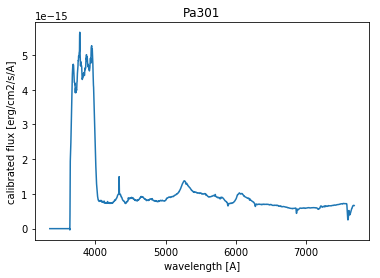

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.0085507e-15 1.0073589e-15 1.0077991e-15 1.0083281e-15 1.0057234e-15]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [9.603194e-16 9.570062e-16 9.486444e-16 9.446737e-16 9.390237e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.9215479e-16 7.8845289e-16 7.8688667e-16 7.8166948e-16 7.7535638e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.2343686e-16 7.2420809e-16 7.2495109e-16 7.2508858e-16 7.2577928e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.4978984e-16 6.3787044e-16 6.4236152e-16 6.6179881e-16 6.8491095e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.9448290e-16 6.9366990e-16 6.9637257e-16 6.9524305e-16 6.9459396e-16]


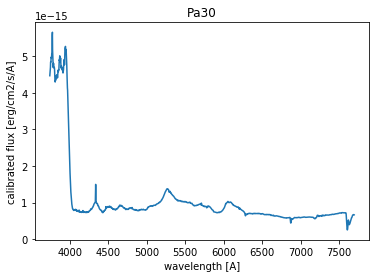

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1a>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1415, 1433], 'ObjectAreas': [[1434, 1490]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1a/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1509, 1529], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 18)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.4165907e-18 1.2455166e-18 1.2140855e-18 ... 1.2954918e-18
  1.21

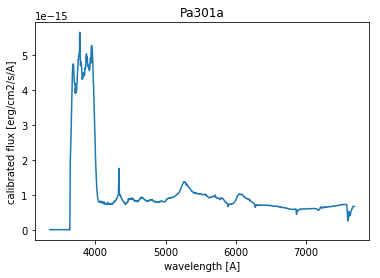

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.0122399e-15 1.0116062e-15 1.0147256e-15 1.0162529e-15 1.0137892e-15]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [9.626218e-16 9.613574e-16 9.552187e-16 9.523933e-16 9.467407e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.9539914e-16 7.9393277e-16 7.9128140e-16 7.8471266e-16 7.7741399e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.2562210e-16 7.2684771e-16 7.2903914e-16 7.3318124e-16 7.2983191e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.5170048e-16 6.4028756e-16 6.4599005e-16 6.6423053e-16 6.8627351e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.9613763e-16 6.9822186e-16 6.9785806e-16 6.9570088e-16 6.9669974e-16]


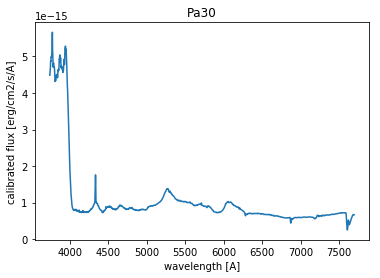

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1a/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1b>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1283, 1308], 'ObjectAreas': [[1323, 1342]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1b/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1416, 1436], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 25)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.1553791e-18 1.2280524e-18 1.2049974e-18 ... 1.1888281e-18
  1.1

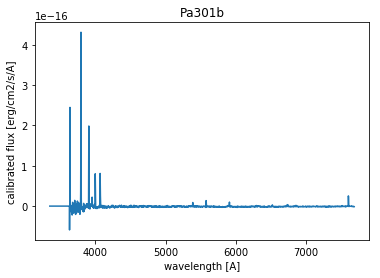

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-1.3505205e-18 -1.4590161e-18 -1.1904905e-18 -3.6675803e-19
 -9.9246515e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-8.1544840e-19 -6.5769823e-19 -4.5232924e-20  5.4468809e-21
 -5.5663579e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-2.2679061e-18 -1.7122916e-18 -1.5913918e-18 -1.3302917e-18
 -9.9611343e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.3001777e-18 1.3509376e-18 7.9055835e-18 9.9072299e-18 2.4012950e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-1.3447314e-18 -6.2760737e-19  4.9114883e-20 -3.3121811e-19
 -1.6066213e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-2.16154991e-18 -1.04331463e-19  3.04934136e-19  8.96639486e-20
 -6.25879386e-19]


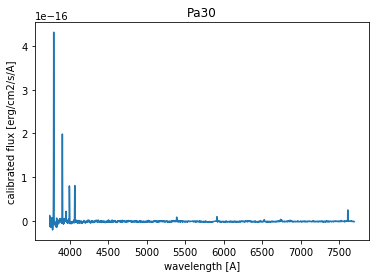

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1b/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1c>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1283, 1308], 'ObjectAreas': [[1386, 1402]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1c/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1416, 1436], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 25)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.1553791e-18 1.2280524e-18 1.2049974e-18 ... 1.1888281e-18
  1.1

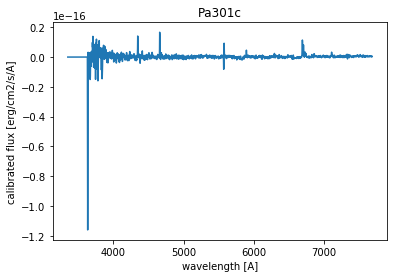

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [3.53395856e-19 1.01444241e-18 1.20601486e-18 1.25652757e-18
 1.06286815e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.1950217e-19 5.9390906e-19 9.8784339e-19 1.1638391e-18 1.2200248e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [ 1.0830689e-20 -3.7534727e-19 -1.0713579e-18 -1.3381091e-18
 -4.3358822e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [ 8.4683318e-19  2.7093360e-19 -4.9574713e-19  7.1596194e-19
  1.1533393e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [ 2.01121159e-19  6.91210731e-20  3.33328248e-19  1.02043585e-19
 -3.43378595e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-4.8983692e-19  1.2930805e-18  7.0364258e-19  1.6624619e-19
  4.9167336e-19]


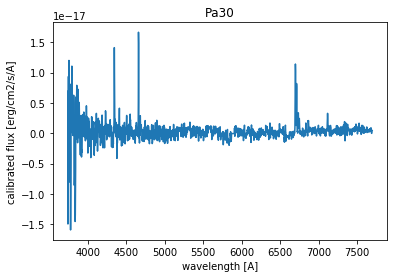

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1c/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1d>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1260, 1277], 'ObjectAreas': [[1478, 1562]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1d/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1563, 1586], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 17)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.1410949e-18 1.1781475e-18 1.2056173e-18 ... 1.1859383e-18
  1.2

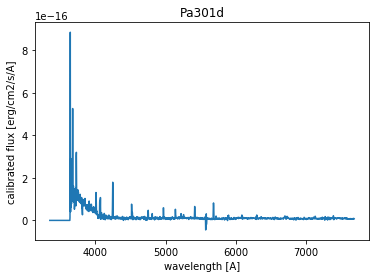

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.4894226e-17 9.2803916e-18 7.1181646e-18 5.3560565e-18 7.6300513e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.73423220e-18 9.59645812e-18 1.16262105e-17 1.19639036e-17
 8.72748255e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [9.05633400e-18 1.05676476e-17 9.73188082e-18 6.81270088e-18
 7.39708000e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.05413962e-17 1.04311578e-17 1.04451835e-17 1.25970475e-17
 9.67096724e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [8.1294781e-18 9.4285462e-18 1.3271159e-17 1.2537423e-17 7.5334382e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.2185063e-17 9.1621784e-18 1.0478751e-17 1.0106687e-17 9.9037400e-18]


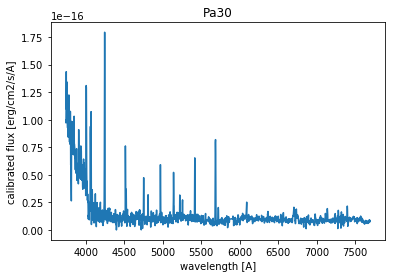

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1d/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1e>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.41189
{'SkyLeft': [1563, 1586], 'ObjectAreas': [[1650, 1710]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-1e/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1744, 1774], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 23)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.2484459e-18 1.1846790e-18 1.1655790e-18 ... 1.1612881e-18
  1.1

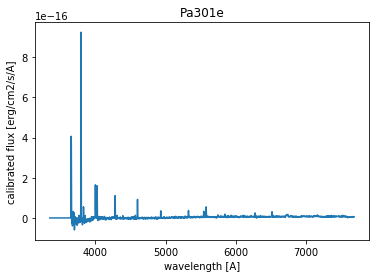

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [5.9123756e-18 4.8487036e-18 4.0029578e-18 2.8978325e-18 5.9450480e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.8260087e-18 8.1478622e-18 3.3290856e-18 3.3760599e-18 5.0022540e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [4.7785339e-18 4.9946084e-18 5.0221092e-18 2.8739090e-18 5.4108051e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.8218017e-18 7.8422529e-18 3.0697609e-18 2.7070532e-18 4.1710198e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [2.5166168e-17 1.7652512e-17 7.3217925e-18 4.7284750e-18 7.4525433e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [5.2695053e-18 3.8544193e-18 4.8404740e-18 5.3824320e-18 8.5474864e-18]


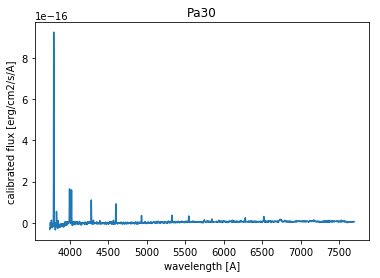

time =  2016-07-08 04:16:41
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-1e/Pa30_GT080716.fits>
directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1264, 1320], 'ObjectAreas': [[1406, 1421]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1501, 1539], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 56)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.8683848e-18 2.7553529e-18 2.8078671e-18 ... 2.8154391e-18
  2.83

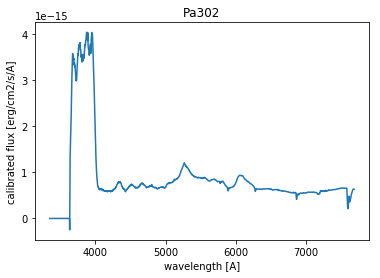

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [8.8977931e-16 8.8621913e-16 8.8469955e-16 8.8375495e-16 8.8420404e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [8.4509144e-16 8.4196033e-16 8.3966360e-16 8.3874928e-16 8.3962014e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.1786730e-16 7.1432348e-16 7.1109845e-16 7.0694159e-16 7.0170740e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.6343374e-16 6.6484765e-16 6.6683039e-16 6.6911256e-16 6.6603275e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [5.9958741e-16 5.8638566e-16 5.9040092e-16 6.0529409e-16 6.2097791e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.3598887e-16 6.3613874e-16 6.3486935e-16 6.3256251e-16 6.3157492e-16]


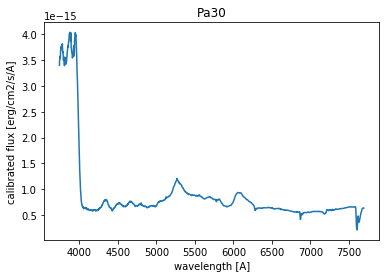

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2/Pa30_GT080716.fits>


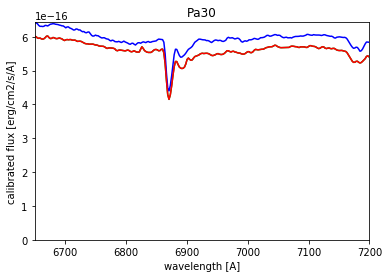

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2/Pa30_GT080716_min.fits>


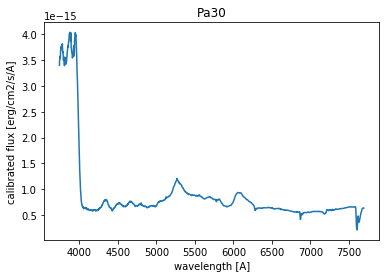

directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2a>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1264, 1320], 'ObjectAreas': [[1372, 1461]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2a/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1501, 1539], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 56)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.8683848e-18 2.7553529e-18 2.8078671e-18 ... 2.8154391e-18
  2.8304028e-18 2.7649186e-18]
 [2.8355962e-18 2.7607831e-18 2.8594827e-18 ... 2.7828345e-18
  2.8249872e-18 2.7306101e-18]
 [2.8125853e-18 2.7674194e-18 2.8

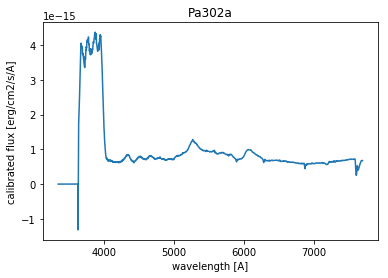

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [9.493224e-16 9.430514e-16 9.433027e-16 9.445764e-16 9.473207e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [9.148343e-16 9.145144e-16 9.045490e-16 8.954627e-16 8.989219e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.6835751e-16 7.6331036e-16 7.5830063e-16 7.5452604e-16 7.4785825e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [7.0368395e-16 7.0703608e-16 7.1116950e-16 7.1084725e-16 7.0605797e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.319019e-16 6.185962e-16 6.277602e-16 6.458980e-16 6.613749e-16]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.7774277e-16 6.7533916e-16 6.7198263e-16 6.7156176e-16 6.7143068e-16]


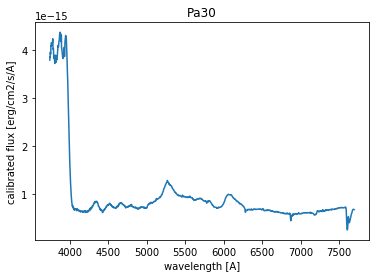

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2a/Pa30_GT080716.fits>


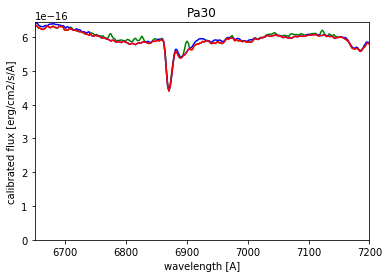

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2a/Pa30_GT080716_min.fits>


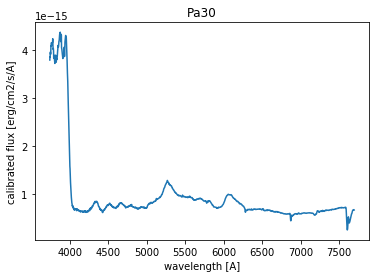

directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2b>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1200, 1264], 'ObjectAreas': [[1278, 1296]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2b/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1369, 1382], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 64)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.8384546e-18 2.6697194e-18 2.8148902e-18 ... 2.7708873e-18
  2.7079945e-18 2.7017384e-18]
 [2.8608066e-18 2.7813712e-18 2.7968912e-18 ... 2.7031458e-18
  2.6561475e-18 2.7165438e-18]
 [2.9112094e-18 2.8751065e-18 2.7

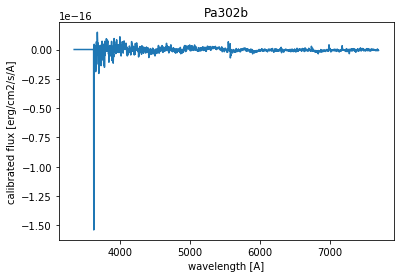

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-6.3439149e-19 -4.8966197e-20  1.3527939e-19 -2.6018966e-20
  1.4184286e-20]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-5.1568714e-19 -1.7558877e-18 -2.0560718e-18 -1.5270755e-18
 -2.4433892e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-1.8523895e-18 -2.4135648e-18 -1.1051020e-18 -5.3347607e-19
  2.0908624e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-1.4383896e-18 -1.5710577e-18 -2.3103248e-18 -1.6695625e-18
 -1.1467310e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-8.8506258e-21  4.5614492e-19 -8.8126354e-19 -1.3012058e-18
 -8.7918463e-19]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [-2.7348456e-18 -1.8326379e-18 -1.0494403e-18 -8.3766078e-19
 -6.9867449e-19]


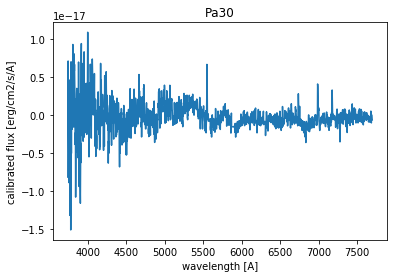

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2b/Pa30_GT080716.fits>


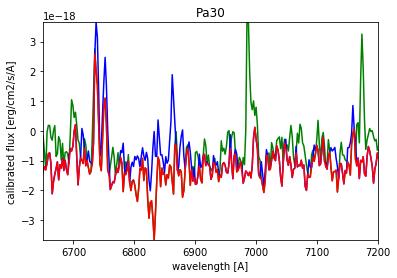

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2b/Pa30_GT080716_min.fits>


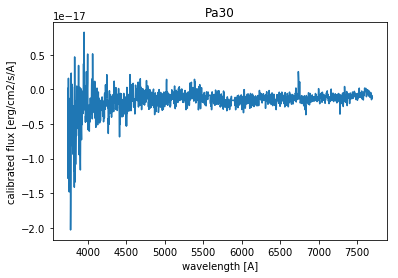

directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2c>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1264, 1320], 'ObjectAreas': [[1337, 1355]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2c/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1369, 1382], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 56)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.8683848e-18 2.7553529e-18 2.8078671e-18 ... 2.8154391e-18
  2.8304028e-18 2.7649186e-18]
 [2.8355962e-18 2.7607831e-18 2.8594827e-18 ... 2.7828345e-18
  2.8249872e-18 2.7306101e-18]
 [2.8125853e-18 2.7674194e-18 2.8

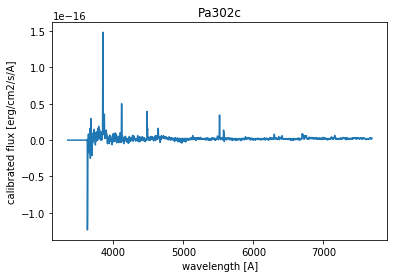

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [2.2298388e-18 3.0708423e-18 2.4925289e-18 2.2016940e-18 1.9453611e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.9837915e-18 1.7068975e-18 1.0766976e-18 8.8058215e-19 2.1916312e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [2.0727610e-18 1.7416768e-18 1.0057093e-18 1.6844737e-18 1.6283325e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.9052422e-18 1.9484860e-18 2.3158309e-18 2.0971957e-18 2.2364985e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.2170381e-18 1.6531223e-18 2.7378948e-18 2.1666973e-18 1.8035978e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [2.8860218e-18 3.4798306e-18 3.1357755e-18 3.1507239e-18 2.3663114e-18]


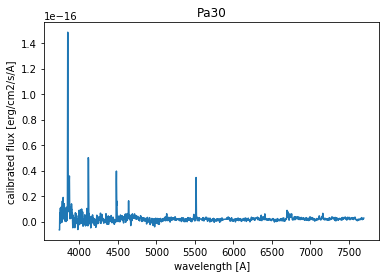

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2c/Pa30_GT080716.fits>


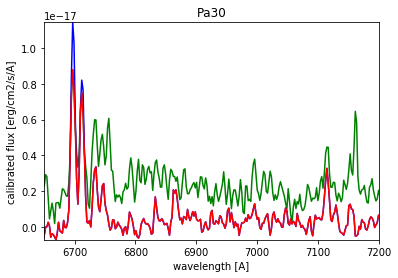

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2c/Pa30_GT080716_min.fits>


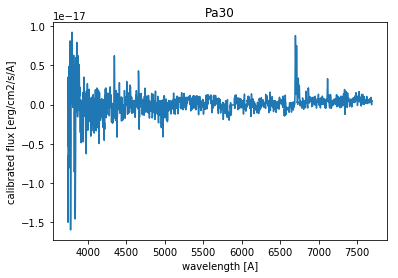

directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2d>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1300, 1320], 'ObjectAreas': [[1433, 1537]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2d/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1568, 1600], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 20)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.6965071e-18 2.7462117e-18 2.7281126e-18 ... 2.8154391e-18
  2.8304028e-18 2.7649186e-18]
 [2.7316538e-18 2.7736981e-18 2.7244904e-18 ... 2.7828345e-18
  2.8249872e-18 2.7306101e-18]
 [2.7973929e-18 2.8442841e-18 2.8

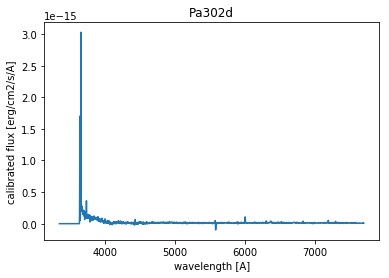

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.5321086e-17 1.3013291e-17 1.4765938e-17 1.2238785e-17 1.0944948e-17]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.05705907e-17 1.11744474e-17 3.89420337e-18 4.07657519e-18
 5.07520139e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.54211050e-17 1.29311863e-17 1.15746018e-17 6.83257969e-18
 1.24557866e-17]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.6608718e-17 8.2667760e-18 1.0704405e-17 1.7760239e-17 1.8009080e-17]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.1914899e-17 1.1770881e-17 1.6148223e-17 1.5773884e-17 1.2990253e-17]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [1.61002434e-17 1.11856756e-17 1.18879734e-17 9.37662826e-18
 1.21035160e-17]


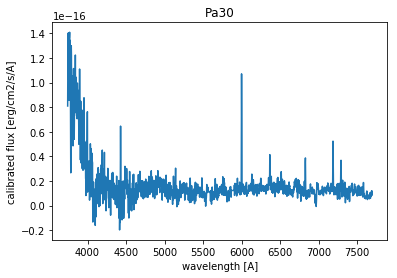

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2d/Pa30_GT080716.fits>


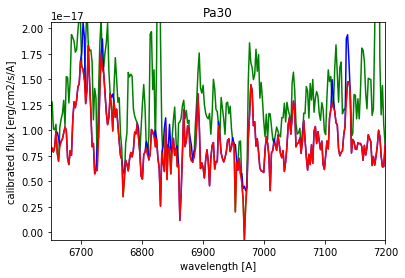

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2d/Pa30_GT080716_min.fits>


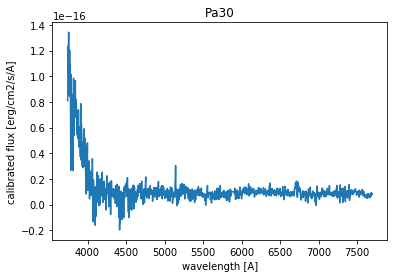

directory = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2e>
['__doc__', '__getattr__', '__init__', '__module__', '__name__', '__setattr__', '_moduleInit', 'getAllMatches', 'mmdict', 'module']
airmass =  1.354028
{'SkyLeft': [1568, 1600], 'ObjectAreas': [[1604, 1663]], 'FName': 'Laurence/GTC4-16AMEX/OB0065-2e/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1666, 1686], 'ylim': [0, 0], 'OName': 'Pa30'}
imageData.shape =  (2051, 32)
len(imageData.shape) =  2
imageData =  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [2.7364576e-18 2.9096669e-18 2.7701480e-18 ... 2.8302194e-18
  2.8053568e-18 2.8654845e-18]
 [2.7973637e-18 2.8495005e-18 2.7683880e-18 ... 2.7324702e-18
  2.6509608e-18 2.8105655e-18]
 [2.8876931e-18 2.7656304e-18 2.8

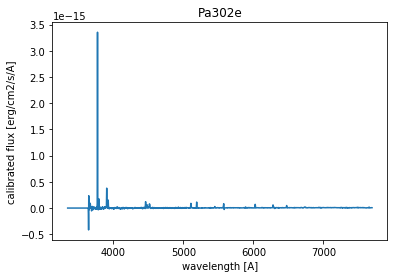

spectrum.shape =  (1865,)
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [4.3018694e-18 3.9481149e-18 5.9383826e-18 4.9718605e-18 6.5216442e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [4.8973017e-18 4.2196940e-18 5.3648701e-18 5.6759111e-18 5.3239942e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [6.4203079e-18 5.1710832e-18 5.3039259e-18 8.7189494e-18 5.7973297e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [5.5518444e-18 3.5064823e-18 3.8588654e-18 7.8511848e-18 5.7944378e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [5.90832017e-17 5.63680839e-17 2.97124732e-17 1.36244844e-17
 7.96584856e-18]
imageData.shape =  (5,)
len(imageData.shape) =  1
imageData =  [4.6693163e-18 6.1747825e-18 4.2663230e-18 2.3214855e-18 4.2932254e-18]


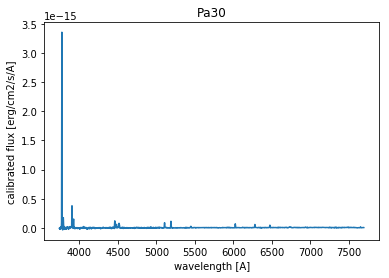

time =  2016-07-08 04:54:31
datestr = <080716>
specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2e/Pa30_GT080716.fits>


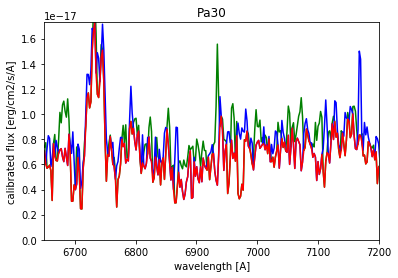

specOutName = </Volumes/obiwan/azuri/spectra/IPHAS_GTC/Laurence/GTC4-16AMEX/OB0065-2e/Pa30_GT080716_min.fits>


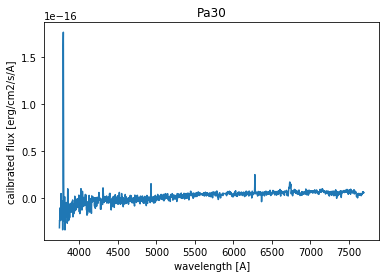

In [9]:
#tab = [
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits', 'ylim' : [-30000.,50000.], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[612,702], 'SkyRight':[1823,1855], 'ObjectAreas':[[1090,1125],[1164,1212],[1238,1252],[1267,1295],[1307,1353],[1367,1444],[1495,1516],[1530,1556],[1600,1650],[1665,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt.fits', 'ylim' : [-50000.,180000], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt.fits', 'ylim' : [-3000.,25000.], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1269,1295],[1311,1359]]},#line at 6559, 6580
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1534,1554],[1570,1662]]},#lines at 5005, 6560, 6580
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'ylim' : [,], 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt.fits', 'ylim' : [-23000.,70000.], 'OName': 'IPHASXJ193849', 'SkyLeft':[428,534], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits', 'ylim' : [,], 'OName': 'ldu18', 'SkyLeft':[1122,1170], 'SkyRight':[1388,1504], 'ObjectAreas':[[1266,1344]]},#lines at 4956, 5005
#]

#tab=[{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1000,100000], 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]}]
tab=[{'FName': 'Laurence/GTC4-16AMEX/OB0065-1/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1415,1444], 'SkyRight':[1509,1529], 'ObjectAreas':[[1443,1488]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-1a/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1415,1433], 'SkyRight':[1509,1529], 'ObjectAreas':[[1434,1490]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-1b/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1283,1308], 'SkyRight':[1416,1436], 'ObjectAreas':[[1323,1342]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-1c/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1283,1308], 'SkyRight':[1416,1436], 'ObjectAreas':[[1386,1402]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-1d/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1260,1277], 'SkyRight':[1563,1586], 'ObjectAreas':[[1478,1562]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-1e/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1563,1586], 'SkyRight':[1744,1774], 'ObjectAreas':[[1650,1710]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1264,1320], 'SkyRight':[1501,1539], 'ObjectAreas':[[1406,1421]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2a/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1264,1320], 'SkyRight':[1501,1539], 'ObjectAreas':[[1372,1461]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2b/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1200,1264], 'SkyRight':[1369,1382], 'ObjectAreas':[[1278,1296]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2c/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1264,1320], 'SkyRight':[1369,1382], 'ObjectAreas':[[1337,1355]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2d/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1300,1320], 'SkyRight':[1568,1600], 'ObjectAreas':[[1433,1537]]},
     {'FName': 'Laurence/GTC4-16AMEX/OB0065-2e/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Pa30', 'SkyLeft':[1568,1600], 'SkyRight':[1666,1686], 'ObjectAreas':[[1604,1663]]},
    ]

iSpec = 0
spectra = []
for obs in tab:
    directory = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'][0:obs['FName'].rfind('/')])
    print 'directory = <'+directory+'>'
    print dir(iraf)
#    iraf.user.reduce_gtcmos(indirs=directory)
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    try:
        hdulist = pyfits.open(image_file)
    except:
        print 'file <'+image_file+'> not found'
        image_file = image_file[0:image_file.rfind('_x')]+image_file[image_file.rfind('_x')+2:]
        print 'trying <'+image_file+'>'
        try:
            hdulist = pyfits.open(image_file)
        except:
            print 'file <'+image_file+'> not found'

#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    wavelength = getWavelength(header)
    image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
    imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

    obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])

    obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]

    spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
    for iRow in range(spectrum.shape[0]):
        spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]

    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'] + obs['FName'][obs['FName'].rfind('-')+1:obs['FName'].rfind('/')])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- mark sky and object areas in original image
    markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

    hdulist[0].data = obsCols
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

    hdulist[0].data = obsColsSmoothed
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

    hdulist[0].data = image_data
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

    hdulist[0].data = imageSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)

    # --- cut off blue end
    idx = findFirstIdxWithValGT(wavelength, 3740.)
    wavelength = wavelength[idx:]
    spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
    print 'spectrum.shape = ',spectrum.shape

    # --- interpolate over 5567-5590 (5577 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5567.)
    idxH = findFirstIdxWithValGT(wavelength, 5590.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- interpolate over 5867-5905 (~5885 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5867.)
    idxH = findFirstIdxWithValGT(wavelength, 5905.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- interpolate over 6290-6308 (~6299 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 6290.)
    idxH = findFirstIdxWithValGT(wavelength, 6308.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

#    fitsName = image_file[0:image_file.rfind('.')]+'s.fits'
#    write1DFits(spectrum, fitsName)
    
    # --- continuum normalize spectrum
#    fitsNameOut = fitsName[0:fitsName.rfind('.')]+'c.fits'
#    if os.path.exists(fitsNameOut):
#        os.remove(fitsNameOut)
#    iraf.continuum(fitsName,
#                   fitsNameOut,
#                   ask="yes",
#                   lines="*",
#                   bands="1",
#                   type="ratio",
#                   replace=False,
#                   wavescale=True,
#                   logscale=False,
#                   override=False,
#                   listonly=False,
#                   logfiles="logfile",
#                   interactive=True,
#                   sample="*",
#                   naverage=1,
#                   function="spline3",
#                   order=6,
#                   low_reject=5.,
#                   high_reject=1.,
#                   niterate=10,
#                   grow=1.,
#                   markrej=True)
#    spectrum=read1DFits(fitsNameOut)

#    pymodelfit.fitgui.FitGui(xdata=wavelength, ydata=spectrum, weights=None, model='smoothspline', include_models=None, exclude_models=None, fittype=None, **traits)
    
    # --- plot cleaned spectrum
    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- write spectrum
    hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
    hdulist[0].header['CRPIX1'] = header['CRPIX2']
    hdulist[0].header['CRVAL1'] = wavelength[0]
    hdulist[0].header['CDELT1'] = header['CDELT2']
    hdulist[0].header['CD1_1'] = header['CD2_2']
    hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
    obsdate = getDateTime(header['DATE-OBS'])
    datestr = obsdate.strftime('%d%m%y')
    print 'datestr = <'+datestr+'>'
    specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/'+obs['FName'][0:obs['FName'].rfind('/')],obs['OName']+'_GT'+datestr+'.fits')
    print 'specOutName = <'+specOutName+'>'

    hdulist.writeto(specOutName, clobber=True)

    with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
        for i in range(len(wavelength)):
            f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
    spectra.append([wavelength, spectrum])
    if iSpec >= len(tab) / 2:
        plt.plot(spectra[iSpec][0],spectra[iSpec][1],'g-')
        plt.plot(spectra[iSpec-int(len(tab)/2)][0],spectra[iSpec-int(len(tab)/2)][1],'b-')
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        xMin = 6650.
        xMax = 7200.
        plt.xlim(xMin,xMax)
        yMin = 1.
        yMax = 0.
        specNew = spectrum
        for i in range(len(wavelength)):
            if spectra[iSpec - int(len(tab) / 2)][1][i] < specNew[i]:
                specNew[i] = spectra[iSpec - int(len(tab) / 2)][1][i]
            if np.abs(wavelength[i] - spectra[iSpec - int(len(tab) / 2)][0][i]) > 0.01:
                print 'PROBLEM: np.abs(wavelength[i](=',wavelength[i],') - spectra[iSpec - int(len(tab) / 2)][0][i](=',spectra[iSpec - int(len(tab) / 2)][0][i],'))(=',np.abs(wavelength[i] - spectra[iSpec - int(len(tab) / 2)][0][i]),') > 0.01'
            if (wavelength[i] > xMin) and (wavelength[i] < xMax):
                if spectrum[i] > yMax:
                    yMax = spectrum[i]
                if spectra[iSpec - int(len(tab) / 2)][1][i] > yMax:
                    yMax = spectra[iSpec - int(len(tab) / 2)][1][i]
                if spectra[iSpec - int(len(tab) / 2)][1][i] < yMin:
                    yMin = spectra[iSpec - int(len(tab) / 2)][1][i]
                if spectrum[i] < yMin:
                    yMin = spectrum[i]
        plt.plot(wavelength,specNew,'r-')

        if yMin > 0.:
            yMin = 0.
        plt.ylim(yMin, yMax)
        plt.title(obs['OName'])
        plt.show()
        
        hdulist[0].data = specNew
        specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/'+obs['FName'][0:obs['FName'].rfind('/')],obs['OName']+'_GT'+datestr+'_min.fits')
        print 'specOutName = <'+specOutName+'>'

        hdulist.writeto(specOutName, clobber=True)
        

        # --- plot cleaned spectrum
        plt.plot(wavelength,specNew)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.show()

        # --- continuum normalize spectrum
        fitsNameOut = specOutName[0:specOutName.rfind('.')]+'c.fits'
        if os.path.exists(fitsNameOut):
            os.remove(fitsNameOut)
        if False:
            iraf.continuum(specOutName,
                           fitsNameOut,
                           ask="yes",
                           lines="*",
                           bands="1",
                           type="ratio",
                           replace=False,
                           wavescale=True,
                           logscale=False,
                           override=False,
                           listonly=False,
                           logfiles="logfile",
                           interactive=True,
                           sample="*",
                           naverage=1,
                           function="spline3",
                           order=6,
                           low_reject=5.,
                           high_reject=1.,
                           niterate=10,
                           grow=1.,
                           markrej=True)
        
    iSpec += 1
#    STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab


In [ ]:
import pyfits
import os
execfile("/Users/azuri/entwicklung/python/myUtils.py")# import getDate, findClosestDate

stddates = []
stds = []
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    stdpath = os.path.join(image_file[0:image_file.rfind('/')],'stds')
    tempfile = '/tmp/temp.ls'
    try:
        a = os.system('ls '+stdpath+' > '+tempfile)
        with open(tempfile, 'r') as f:
            line = ''
            for lines in f:
                line = lines.strip()
            std = os.path.join(stdpath,line)
            print 'std = ',std
            hduliststd = pyfits.open(std)
            headerstd = hduliststd[0].header
            stddates.append(getDateTime(headerstd['DATE-OBS']))
            stds.append(std)
    except:
        """nothing"""

tabstd = [
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits', 'ylim' : [-30000.,50000.], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[612,702], 'SkyRight':[1823,1855], 'ObjectAreas':[[1090,1125],[1164,1212],[1238,1252],[1267,1295],[1307,1353],[1367,1444],[1495,1516],[1530,1556],[1600,1650],[1665,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt.fits', 'ylim' : [-50000.,180000], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt.fits', 'ylim' : [-3000.,25000.], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1269,1295],[1311,1359]]},#line at 6559, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1534,1554],[1570,1662]]},#lines at 5005, 6560, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt.fits', 'ylim' : [-23000.,70000.], 'OName': 'IPHASXJ193849', 'SkyLeft':[428,534], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': 'ldu18', 'SkyLeft':[1122,1170], 'SkyRight':[1388,1504], 'ObjectAreas':[[1266,1344]]},#lines at 4956, 5005
]
for obs in tabstd:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])

    hdulist = pyfits.open(image_file)
    header = hdulist[0].header
#    try:
    if True:
        print 'obs name = ',obs['FName'],': DATE-OBS = ',header['DATE-OBS']
        obsdate = getDateTime(header['DATE-OBS'])
        closestStdDate, closestStdIdx, diffMin = findClosestInTime(obsdate, stddates)
        d = divmod(diffMin,86400)  # days
        h = divmod(d[1],3600)  # hours
        m = divmod(h[1],60)  # minutes
        s = m[1]  # seconds

        print 'closestStdDate = ',closestStdDate,', std = ',stds[closestStdIdx],', diffMin = ',diffMin,' = %d days, %d hours, %d minutes, %d seconds' % (d[0],h[0],m[0],s)
#    except:
#        """nothing"""
os.system('rm '+tempfile)


In [ ]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import ICRS, SkyCoord, EarthLocation, AltAz

image_file = '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits'

hdulist = pyfits.open(image_file)
header = hdulist[0].header

ldu18 = SkyCoord(ICRS, ra=322.46798*u.deg, dec=50.90601*u.deg, obstime=header['DATE-OBS'])
#Observatorio del Roque de los Muchachos La Palma
#28.7573° N, 17.8850° W
del_Roque = EarthLocation(lat=28.7573*u.deg, lon=17.885*u.deg, height=2348*u.m)
ldu18az = ldu18.transform_to(AltAz(obstime=header['DATE-OBS'], location=del_Roque))
print 'ldu18az.secz = ',ldu18az.secz

In [ ]:
fname = '/iraf/iraf/noao/lib/onedstds/oke1990/g158100.dat'
lines = []
with open(fname,'r') as f:
    iLine = 0
    for line in f:
        line = line.split()
        print 'line = ',line
        if iLine == 0:
            lines.append(line[0]+' '+line[1])
        else:
            flux = str(float(line[1])/10.)
            print 'flux = <'+flux+'>'
            lines.append(line[0]+' '+flux+' '+line[2])
        print 'lines[',iLine,'] = <'+lines[iLine]
        iLine += 1
with open(fname,'w') as f:
    f.write("\n".join(lines))

In [ ]:
from pyraf import iraf

def copyHeader(imFrom, imTo):
    hdulistFrom = pyfits.open(imFrom)
    headerFrom = hdulist[0].headerFrom
    
    hdulistTo = pyfits.open(imTo)
    hdulistTo[0].header = headerFrom
    hdulistTo.writeto(imTo, clobber=True)
    
def swapHeaders(imA, imB):
    hdulistA = pyfits.open(imA)
    headerA = hdulistA[0].header
    hdulistB = pyfits.open(imB)
    headerB = hdulistB[0].header
    hdulistA[0].header = headerB
    hdulistB[0].header = headerA
    hdulistA.writeto(imA, clobber=True)
    hdulistB.writeto(imB, clobber=True)

imA = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt.fits"
imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits"

#iraf.imcopy(imA, imA[0:imA.find('.')]+'_temp.fits')
#iraf.imcopy(imB, imB[0:imB.find('.')]+'_temp.fits')

swapHeaders(imA, imB)

In [ ]:
def compareHeaders(imA, imB):
    hdulistA = pyfits.open(imA)
    headerA = hdulistA[0].header
    hdulistB = pyfits.open(imB)
    headerB = hdulistB[0].header
    for key in headerA.keys():
        print 'headerA[',key,'] = ',headerA[key],', headerB[',key,'] = ',headerB[key]

imA = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt.fits"
imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits"
compareHeaders(imA, imB)

imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_temp.fits"
compareHeaders(imA, imB)


In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord, FK5

gc = SkyCoord(ra=23.903139, dec=74.926083, unit='deg', frame=FK5, equinox='J2000.0')
gc.fk5
gc.icrs

In [ ]:

tab = [
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ194645', 'SkyLeft':[1114,1156], 'SkyRight':[1351,1418], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
#{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.15e-15,0.3e-15], 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1291,1303], 'SkyRight':[1359,1380], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
##{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1090,1250], 'SkyRight':[1552,1661], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
]
i=1
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    hdulist = pyfits.open(image_file)
#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    if True:
        wavelength = getWavelength(header)
        image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
        imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

        obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])
        
        obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
        
        spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
        for iRow in range(spectrum.shape[0]):
            spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]
        
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()
        
        # --- mark sky and object areas in original image
        markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

        hdulist[0].data = obsCols
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

        hdulist[0].data = obsColsSmoothed
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

        hdulist[0].data = image_data
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

        hdulist[0].data = imageSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

        hdulist[0].data = imageMinusSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)
        
        # --- cut off blue end
        idx = findFirstIdxWithValGT(wavelength, 3700.)
        wavelength = wavelength[idx:]
        spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
#        print 'spectrum.shape = ',spectrum.shape
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5567.)
        idxH = findFirstIdxWithValGT(wavelength, 5590.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5867.)
        idxH = findFirstIdxWithValGT(wavelength, 5905.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- plot cleaned spectrum
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()

        # --- write spectrum
        hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
        hdulist[0].header['CRPIX1'] = header['CRPIX2']
        hdulist[0].header['CRVAL1'] = wavelength[0]
        hdulist[0].header['CDELT1'] = header['CDELT2']
        hdulist[0].header['CD1_1'] = header['CD2_2']
        hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
        obsdate = getDateTime(header['DATE-OBS'])
        datestr = obsdate.strftime('%d%m%y')
        print 'datestr = <'+datestr+'>'
        specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['OName']+'_GT'+datestr+'.fits')

        hdulist.writeto(specOutName, clobber=True)

        with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
            for i in range(len(wavelength)):
                f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#        STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab

In [ ]:
%matplotlib inline
wavelength = []
spectrum = []
with open('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal_spec.dat','r') as f:
    for lines in f:
        line = lines.split()
        wavelength.append(float(line[0]))
        spectrum.append(float(line[1]))
plt.plot(wavelength,spectrum)
plt.xlabel('wavelength [A]')
plt.ylabel('calibrated flux [erg/cm2/s/A]')
plt.xlim(6472.0, 7178.0)
plt.ylim(-0.1e-15, 1.0e-15)
plt.show()

In [ ]:
from astropy.io import fits
import numpy as np

def combineHDUs(inFileName, headFileName, outFileName):

    inhdulist = fits.open(inFileName)
    inhdulist.info()
    
    headhdulist = fits.open(headFileName)
    headDataSec = headhdulist[0].data
    print 'headDataSec.shape = ',headDataSec.shape

    dataSecA = inhdulist[1].data
    print 'dataSecA = ',dataSecA
    print 'len(dataSecA) = ',len(dataSecA)
    print 'len(dataSecA[0]) = ',len(dataSecA[0])
    dataSecB = inhdulist[2].data

    headDataSec[0:len(dataSecA),0:len(dataSecA[0])] = dataSecA#[:,:len(dataSecA[0])]
    headDataSec[0:len(dataSecA),headDataSec.shape[1] - len(dataSecA[0]):] = dataSecB#[:len(dataSecA),38:]
    headhdulist.writeto(outFileName, overwrite=True)
#    hdus = []
#    hdus.append(fits.PrimaryHDU())
#    hdus[0].header = header
#    hdus.append(fits.ImageHDU(zerosArray))
#    fits.HDUList(hdus).writeto(outFileName, overwrite=True)

combineHDUs('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/object/0000969223-20160710-OSIRIS-OsirisLongSlitSpectroscopy.fits',
            '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av.fits',
            '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/0000969223-20160710-OSIRIS-OsirisLongSlitSpectroscopy.fits')

In [ ]:
tab = [
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ205943', 'SkyLeft':[1090,1143], 'SkyRight':[1348,1403], 'ObjectAreas':[[1291,1304],[1317,1329]]},#compact, lines at 4858, 4956, 5005
]
i=1
for obs in tab:
    directory = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'][0:obs['FName'].rfind('/')])
    print 'directory = <'+directory+'>'
    print dir(iraf)
#    iraf.user.reduce_gtcmos(indirs=directory)
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    try:
        hdulist = pyfits.open(image_file)
    except:
        print 'file <'+image_file+'> not found'
        image_file = image_file[0:image_file.rfind('_x')]+image_file[image_file.rfind('_x')+2:]
        print 'trying <'+image_file+'>'
        try:
            hdulist = pyfits.open(image_file)
        except:
            print 'file <'+image_file+'> not found'

#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    wavelength = getWavelength(header)
    image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
    imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

    obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])

    obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]

    spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
    for iRow in range(spectrum.shape[0]):
        spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]

    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- mark sky and object areas in original image
    markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

    hdulist[0].data = obsCols
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

    hdulist[0].data = obsColsSmoothed
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

    hdulist[0].data = image_data
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

    hdulist[0].data = imageSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)

    hdulist[0].data = imageMinusSky
    nCols = 0
    for area in obs['ObjectAreas']:
        hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
        nCols += area[1]-area[0]
    markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
    hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)

    # --- cut off blue end
    idx = findFirstIdxWithValGT(wavelength, 3700.)
    wavelength = wavelength[idx:]
    spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
#        print 'spectrum.shape = ',spectrum.shape

    # --- interpolate over 5567-5590 (5577 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5567.)
    idxH = findFirstIdxWithValGT(wavelength, 5590.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- interpolate over 5567-5590 (5577 OII sky line)
    idxL = findFirstIdxWithValGT(wavelength, 5867.)
    idxH = findFirstIdxWithValGT(wavelength, 5905.)
    spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])

    # --- plot cleaned spectrum
    plt.plot(wavelength,spectrum)
    plt.xlabel('wavelength [A]')
    yLabel = 'calibrated flux [erg/cm2/s/A]'
    if obs['FName'].find("_cal") < 0:
        print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
        yLabel = 'counts [ADU]'
    plt.ylabel(yLabel)
    if obs['ylim'][1] > 0:
        plt.ylim(obs['ylim'][0],obs['ylim'][1])
    plt.title(obs['OName'])
    plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
    plt.show()

    # --- write spectrum
    hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
    hdulist[0].header['CRPIX1'] = header['CRPIX2']
    hdulist[0].header['CRVAL1'] = wavelength[0]
    hdulist[0].header['CDELT1'] = header['CDELT2']
    hdulist[0].header['CD1_1'] = header['CD2_2']
    hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
    obsdate = getDateTime(header['DATE-OBS'])
    datestr = obsdate.strftime('%d%m%y')
    print 'datestr = <'+datestr+'>'
    specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['OName']+'_GT'+datestr+'.fits')

    hdulist.writeto(specOutName, clobber=True)

    with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
        for i in range(len(wavelength)):
            f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
    STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab


In [ ]:
from astropy.io import fits as pyfits
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import ICRS, SkyCoord, EarthLocation, AltAz

image_file = '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_x_wl_flt.fits'

hdulist = pyfits.open(image_file)
header = hdulist[0].header

ldu18 = SkyCoord(ICRS, ra=322.46798*u.deg, dec=50.90601*u.deg, obstime=header['DATE-OBS'])
#Observatorio del Roque de los Muchachos La Palma
#28.7573° N, 17.8850° W
del_Roque = EarthLocation(lat=28.7573*u.deg, lon=17.885*u.deg, height=2348*u.m)
ldu18az = ldu18.transform_to(AltAz(obstime=header['DATE-OBS'], location=del_Roque))
print 'airmass of ldu18az = ',ldu18az.secz


In [ ]:
# copy slit images to mosaic